In [1]:
pip install obspy

Note: you may need to restart the kernel to use updated packages.


1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2020-01-01T00:00:00.019538Z - 2020-01-01T00:59:59.994538Z | 40.0 Hz, 144000 samples


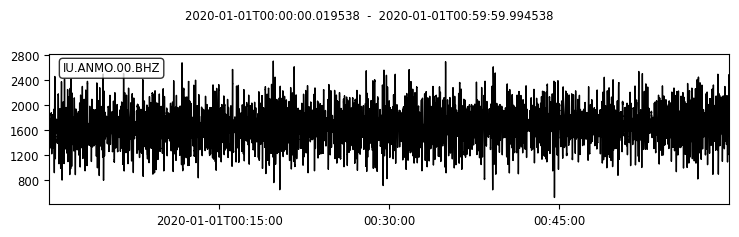

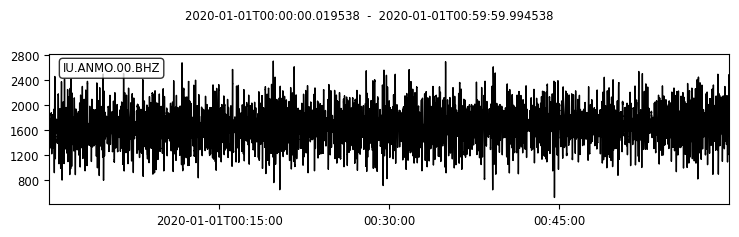

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# Initialize client for IRIS data center
client = Client("IRIS")

# Define parameters
starttime = UTCDateTime("2020-01-01T00:00:00")
endtime = UTCDateTime("2020-01-01T01:00:00")
network = "IU"
station = "ANMO"
location = "00"
channel = "BHZ"

# Fetch waveform data
st = client.get_waveforms(network, station, location, channel, starttime, endtime)

# Preview the data
print(st)
st.plot()


In [4]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

starttime = UTCDateTime("2020-01-01T00:00:00")
endtime = UTCDateTime("2020-01-01T00:30:00")

st = client.get_waveforms("IU", "ANMO", "00", "BHZ", starttime, endtime)
tr = st[0]  # Get the trace


In [5]:
import numpy as np

signal = tr.data
sampling_rate = tr.stats.sampling_rate
n = len(signal)


In [6]:
# Compute FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Take magnitude
magnitude = np.abs(fft_result)


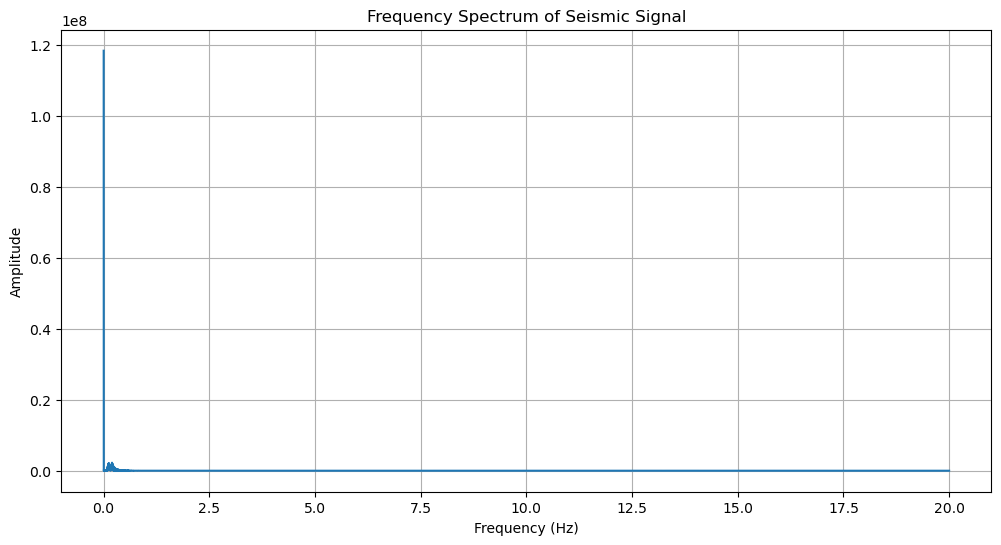

In [7]:
import matplotlib.pyplot as plt

# Plot only the positive frequencies
half_n = n // 2
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:half_n], magnitude[:half_n])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum of Seismic Signal")
plt.grid()
plt.show()


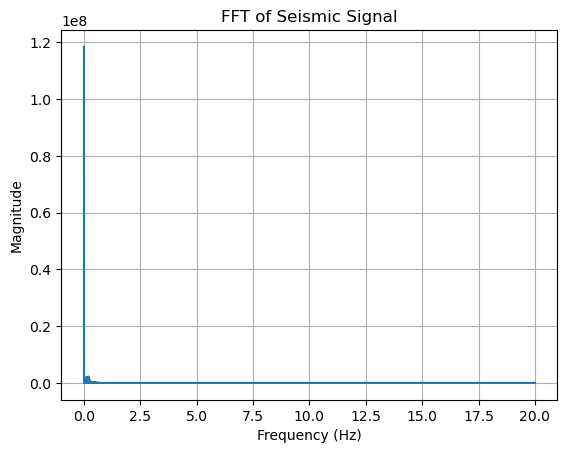

In [8]:
tr = st[0]
signal = tr.data
sampling_rate = tr.stats.sampling_rate

fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

# Plot frequency spectrum
import matplotlib.pyplot as plt

plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of Seismic Signal")
plt.grid()
plt.show()


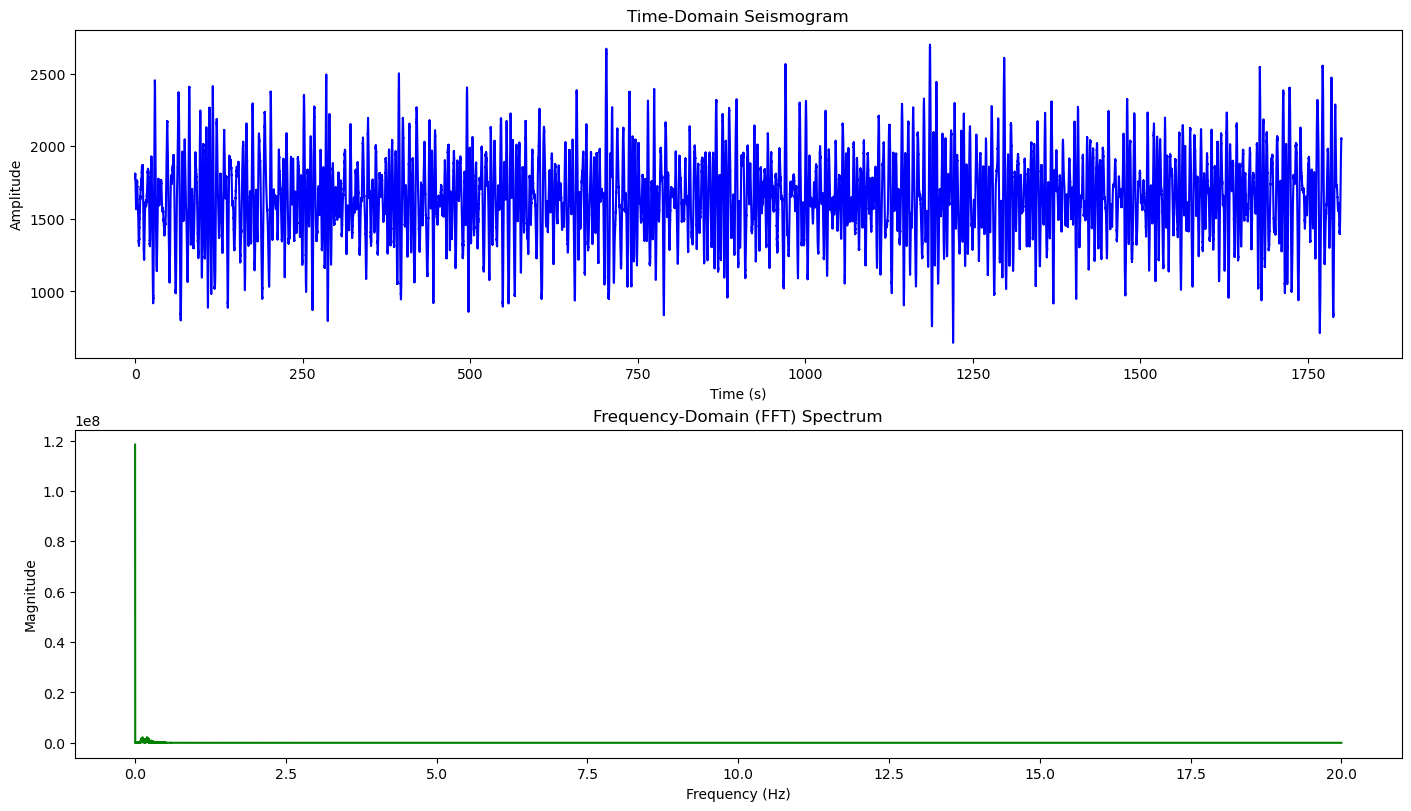

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# Fetch seismic waveform data from IRIS
client = Client("IRIS")
starttime = UTCDateTime("2020-01-01T00:00:00")
endtime = UTCDateTime("2020-01-01T00:30:00")
st = client.get_waveforms("IU", "ANMO", "00", "BHZ", starttime, endtime)
tr = st[0]

# Extract time and signal data
signal = tr.data
sampling_rate = tr.stats.sampling_rate
n = len(signal)
time = np.linspace(0, n / sampling_rate, n)

# Perform FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
magnitude = np.abs(fft_result)

# Plot time-domain and frequency-domain side-by-side
fig, axs = plt.subplots(2, 1, figsize=(14, 8), constrained_layout=True)

# Time-domain plot
axs[0].plot(time, signal, color='blue')
axs[0].set_title("Time-Domain Seismogram")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# Frequency-domain plot (positive frequencies only)
axs[1].plot(frequencies[:n//2], magnitude[:n//2], color='green')
axs[1].set_title("Frequency-Domain (FFT) Spectrum")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")

plt.show()


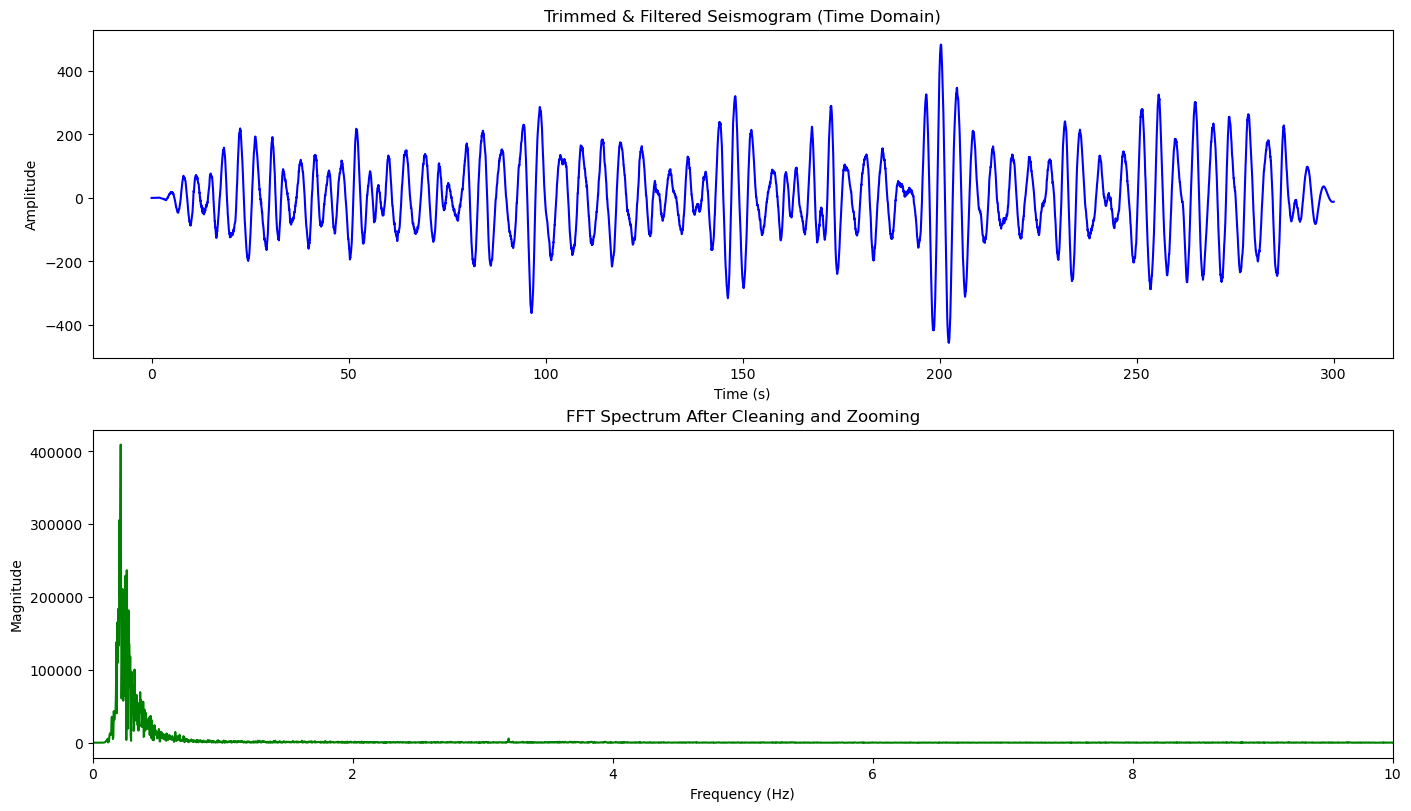

In [ ]:
from obspy.signal.filter import bandpass

tr = st[0]

# Preprocessing to reveal more detail
tr.detrend("linear")                  # Remove trends
tr.taper(max_percentage=0.05)        # Smooth edges
tr.filter("bandpass", freqmin=0.2, freqmax=10.0)  # Focus on relevant frequency range

# Zoom into active region (e.g. 5 to 10 minutes into trace)
tr.trim(starttime + 300, starttime + 600)

# Extract signal and time base
signal = tr.data
sampling_rate = tr.stats.sampling_rate
n = len(signal)
time = np.linspace(0, n / sampling_rate, n)

# Perform FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
magnitude = np.abs(fft_result)

# Plot time and frequency domain
fig, axs = plt.subplots(2, 1, figsize=(14, 8), constrained_layout=True)

# Time-domain plot
axs[0].plot(time, signal, color='blue')
axs[0].set_title("Trimmed & Filtered Seismogram (Time Domain)")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# Frequency-domain plot (zoomed in)
axs[1].plot(frequencies[:n//2], magnitude[:n//2], color='green')
axs[1].set_xlim(0, 10)  # Zoom into most relevant frequencies
axs[1].set_title("FFT Spectrum After Cleaning and Zooming")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")

plt.show()

In [3]:
pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 6.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


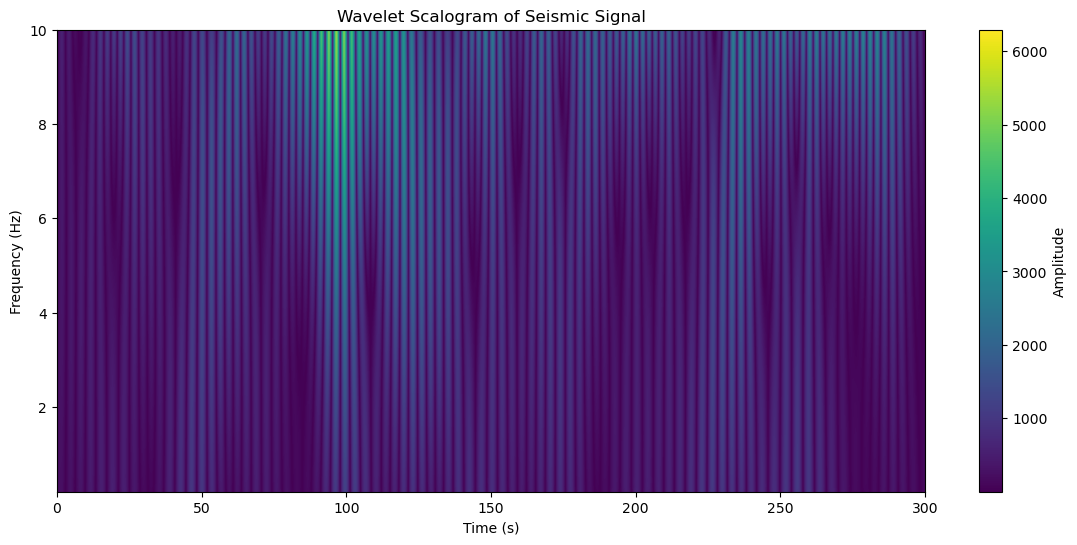

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

tr = st[0]

# Preprocessing
tr.detrend("linear")
tr.taper(max_percentage=0.05)
tr.filter("bandpass", freqmin=0.2, freqmax=10.0)
tr.trim(starttime + 300, starttime + 600)

signal = tr.data
sampling_rate = tr.stats.sampling_rate
time = np.linspace(0, len(signal) / sampling_rate, num=len(signal))

# Step 2: Apply Continuous Wavelet Transform
scales = np.arange(1, 256)
coefficients, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/sampling_rate)

# Step 3: Plot the Scalogram
plt.figure(figsize=(14, 6))
plt.imshow(np.abs(coefficients), extent=[time[0], time[-1], freqs[-1], freqs[0]],
           cmap='viridis', aspect='auto', interpolation='bilinear')
plt.colorbar(label='Amplitude')
plt.title("Wavelet Scalogram of Seismic Signal")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.ylim(0.2, 10)  # Focus on relevant frequency range
plt.show()
